In [75]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

Upload the labels.csv and processed_counts.csv files to colab or your local workspace.

**Copied from Part 1:**
This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [76]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [77]:
labels_pd.index = labels_pd['index']
labels_pd.drop("index", axis=1, inplace=True)
counts_pd.index = counts_pd['Unnamed: 0']
counts_pd.drop("Unnamed: 0", axis=1, inplace=True)

df = counts_pd.merge(labels_pd, left_index=True, right_index=True).dropna()
df

,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,EFHD2,...,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3,bulk_labels
AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,-0.525,...,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011,CD14+ Monocyte
AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490,Dendritic
AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,2.286,...,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490,CD56+ NK
AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490,CD4+/CD25 T Reg
ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,1.932,...,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490,Dendritic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,0.751,...,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593,Dendritic
TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,1.536,...,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490,Dendritic
TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226,CD4+/CD25 T Reg
TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,-0.525,...,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490,CD19+ B


One-hot encode the cell-type.

Shuffle your data. Make sure your labels and the counts are shuffled together.

Split into train and test sets (80:20 split)

In [78]:
categories = df['bulk_labels'].unique()
print(categories)

#one-hot encoding
y = np.zeros((len(df), len(categories)))
for i in range(len(df)):
  cell_type = df.iloc[i]['bulk_labels']
  pos = np.where(categories == cell_type)[0]
  y[i, pos] = 1

#remove label when processing input data
X = df.drop('bulk_labels', axis=1).values

#shuffle and 80:20 split
np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, y_train = X[:int(len(X)*0.6)], y[:int(len(y)*0.6)]
X_val, y_val = X[int(len(X)*0.6):int(len(X)*0.8)], y[int(len(y)*0.6):int(len(y)*0.8)]
X_test, y_test = X[int(len(X)*0.8):], y[int(len(y)*0.8):]

['CD14+ Monocyte' 'Dendritic' 'CD56+ NK' 'CD4+/CD25 T Reg' 'CD19+ B'
 'CD8+ Cytotoxic T' 'CD4+/CD45RO+ Memory' 'CD8+/CD45RA+ Naive Cytotoxic'
 'CD4+/CD45RA+/CD25- Naive T' 'CD34+']


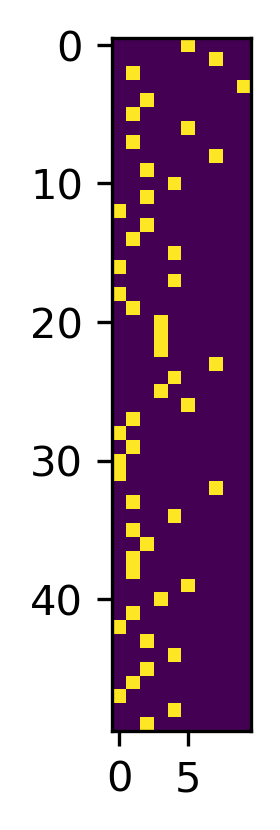

In [79]:
#Visualize the One-hot encoded Prediction Labels
import matplotlib.pyplot as plt
plt.figure(figsize=(9,3), dpi=300)
plt.imshow(y_train[:50])

Apply classification algorithms to the training data, tune on validation data (if present), and evaluate on test data.

You can also apply classification downstream of last week's autoencoder latent space representation.

In [80]:
# Logistic Regression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
params = {'C': [0.1, 1, 10]}
clf = GridSearchCV(lr, params, cv=4, n_jobs=-1)
clf.fit(X_train, y_train.argmax(axis=1))

# evaluate lr on validation set
y_val_pred = clf.predict(X_val)
val_acc = accuracy_score(y_val.argmax(axis=1), y_val_pred)
print(f'Validation accuracy: {val_acc:.4f}')

# evaluate lr on test set
y_test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test.argmax(axis=1), y_test_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test.argmax(axis=1), y_test_pred, average='macro')

# calculate accuracy, precision, recall, and F1 score
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test precision: {precision:.4f}')
print(f'Test recall: {recall:.4f}')
print(f'Test F1 score: {f1:.4f}')

Validation accuracy: 0.8286
Test accuracy: 0.8429
Test precision: 0.8008
Test recall: 0.7234
Test F1 score: 0.7401


c:\Users\Rishabh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [81]:
# SVM
svm = SVC(decision_function_shape='ovr', kernel='rbf', max_iter=1000)
params = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
clf_svm = GridSearchCV(svm, params, cv=5, n_jobs=-1)
clf_svm.fit(X_train, y_train.argmax(axis=1))

# evaluate support vector machine model on validation set
y_val_pred_svm = clf_svm.predict(X_val)
val_acc_svm = accuracy_score(y_val.argmax(axis=1), y_val_pred_svm)
print(f'SVM validation accuracy: {val_acc_svm:.4f}')

# evaluate support vector machine model on test set
y_test_pred_svm = clf_svm.predict(X_test)
test_acc_svm = accuracy_score(y_test.argmax(axis=1), y_test_pred_svm)
print(f'SVM test accuracy: {test_acc_svm:.4f}')

c:\Users\Rishabh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


SVM validation accuracy: 0.3643
SVM test accuracy: 0.3571


In [82]:
# KNN
knn = KNeighborsClassifier()
params = {'n_neighbors': [1, 3, 5, 7]}
clf_knn = GridSearchCV(knn, params, cv=5, n_jobs=-1)
clf_knn.fit(X_train, y_train.argmax(axis=1))

# evaluate k-nearest neighbors model on validation set
y_val_pred_knn = clf_knn.predict(X_val)
val_acc_knn = accuracy_score(y_val.argmax(axis=1), y_val_pred_knn)
print(f'K-Nearest Neighbors validation accuracy: {val_acc_knn:.4f}')

# evaluate k-nearest neighbors model on test set
y_test_pred_knn = clf_knn.predict(X_test)
test_acc_knn = accuracy_score(y_test.argmax(axis=1), y_test_pred_knn)
print(f'K-Nearest Neighbors test accuracy: {test_acc_knn:.4f}')

c:\Users\Rishabh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


K-Nearest Neighbors validation accuracy: 0.5786
K-Nearest Neighbors test accuracy: 0.5714


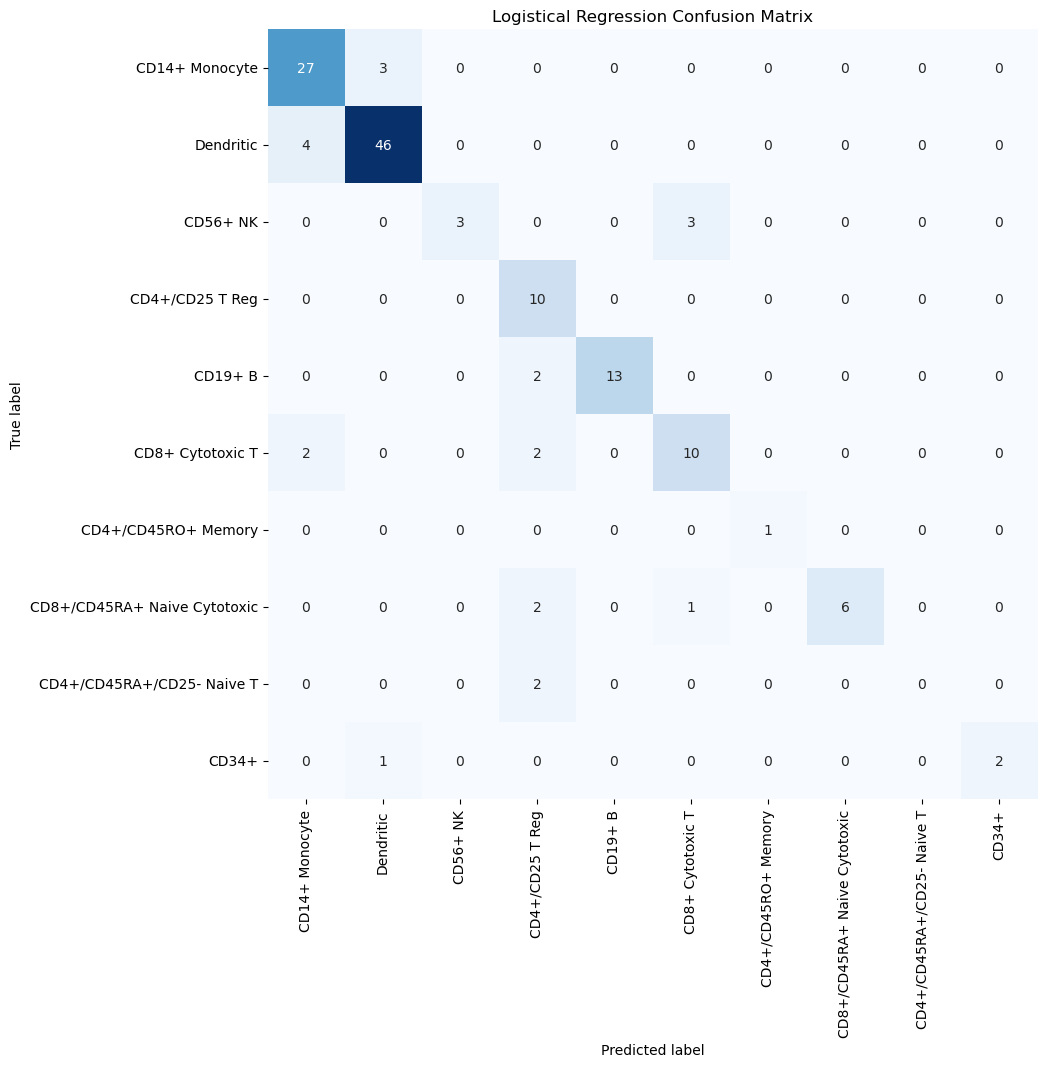

In [83]:
# evaluate lr on test set and create confusion matrix
y_test_pred = clf.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_test_pred)

# plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, square=True,
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Logistical Regression Confusion Matrix')
plt.show()


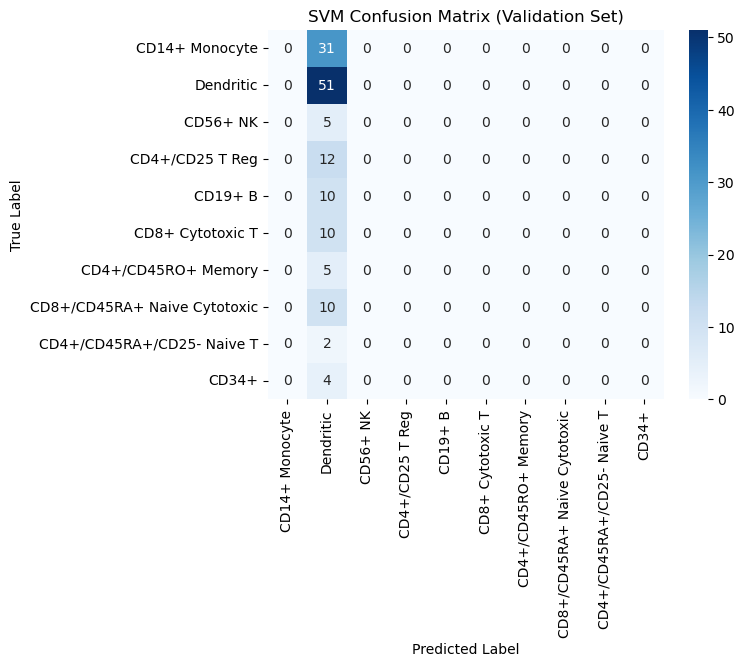

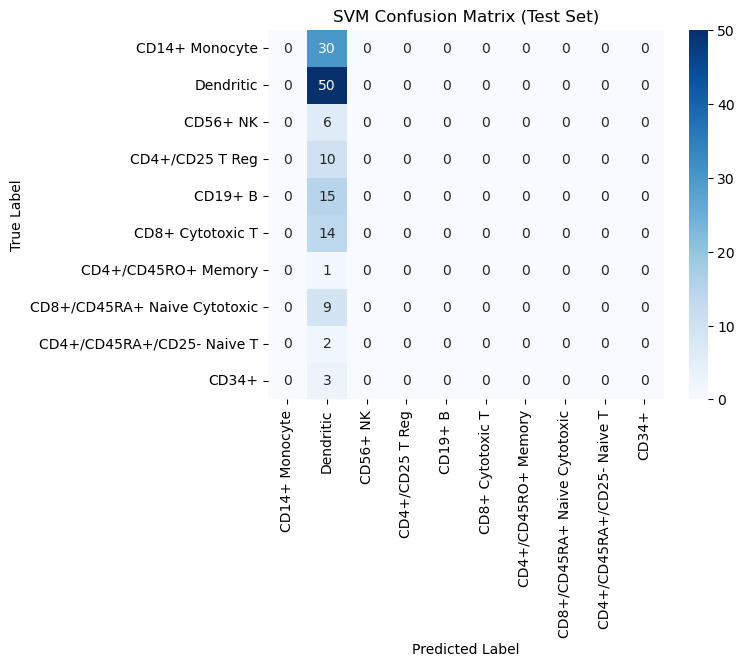

In [84]:
# Visualize SVM
# plot confusion matrix for validation set predictions
cm_val = confusion_matrix(y_val.argmax(axis=1), y_val_pred_svm)
sns.heatmap(cm_val, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories)
plt.title('SVM Confusion Matrix (Validation Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# plot confusion matrix for test set predictions
cm_test = confusion_matrix(y_test.argmax(axis=1), y_test_pred_svm)
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories)
plt.title('SVM Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


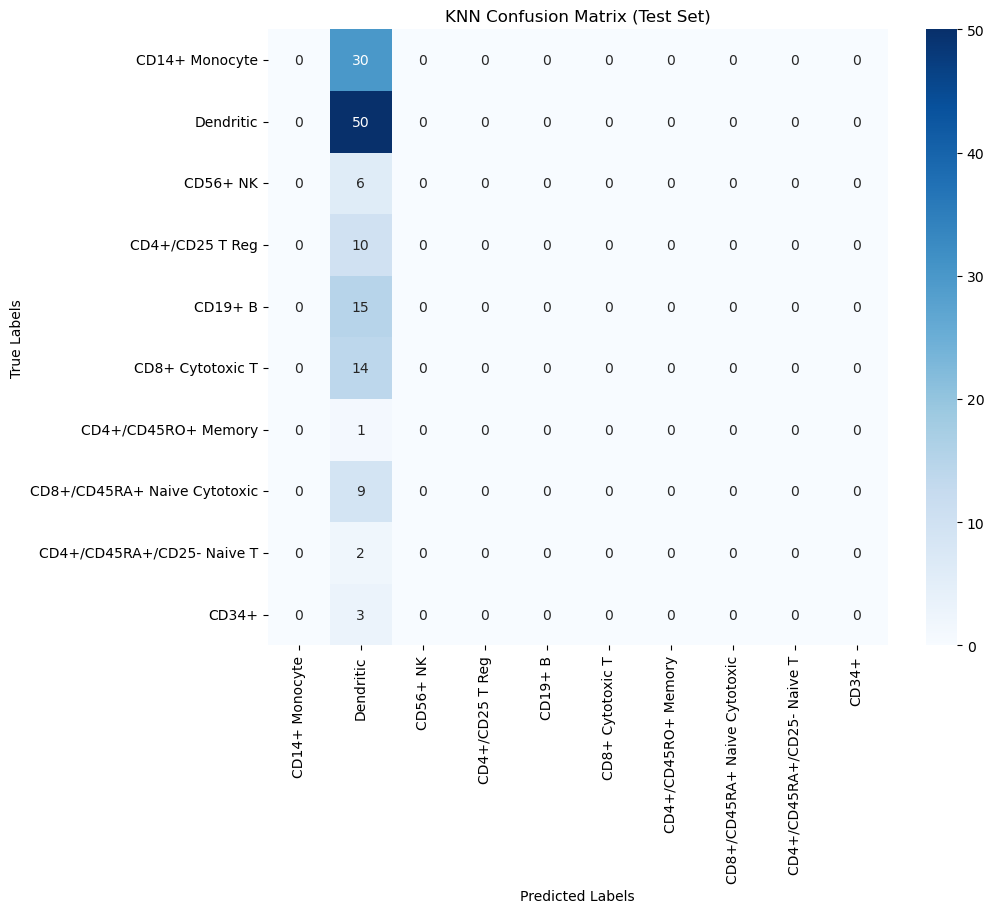

In [85]:
# Visualize KNN

# create confusion matrix
cm_knn = confusion_matrix(y_test.argmax(axis=1), y_test_pred_knn)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories)
plt.title('KNN Confusion Matrix (Test Set)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()